## 1. Introduction

**The Abstract**
<br><br>
Customer reviews are a vital source of feedback for businesses, like restaurants. They provide direct insights into customer experiences, preferences, and satisfaction levels. This represents a **motivation** for this project.
<br><br>
The **audience** is represented by people that can leverage this information, like business owners and managers, who can identify strengths and weaknesses, leading to informed decision-making and enhanced customer experiences.
<br><br>
The intention of this project is to work with a dataset that contains reviews written by customers of several restaurants. These reviews are categorized into two parts: positive and negative, highlighting the sentiment of the customer feedback. Reviews play a crucial role in the reputation and success of restaurants, as they provide valuable insights into customer satisfaction and areas for improvement.



**The Content**

The dataset has 6 columns:

- Country: The country where the restaurant is located.
- Restaurant Name: The name of the restaurant being reviewed.
- Sentiment: The sentiment of the review (Positive/Negative).
- Review Title: The headline or title of the review.
- Review Date: The date when the review was posted.
- Review: The detailed content of the review.


**The Objectives**

There are 2 main goals, and they are:


1.   **Text Preprocessing**

The primary objective of this analysis is to preprocess the review texts to create a corpus that can be used for various Natural Language Processing (NLP) tasks. These tasks may include tokenization, stemming, lemmatization, and sentiment analysis.

2.   **Sentiment Analysis Model Creation**

Develop a machine learning model to analyze the sentiment of the reviews. The goal is to extract meaningful insights and patterns from the data that can help improve the customer experience at these restaurants.

## 2. Libraries to be used and file loading

Let's define the libraries needed.

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Setting up visualization styles
sns.set(style="whitegrid")
plt.style.use('ggplot')

# Text processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string

# Download NLTK data files
nltk.download('punkt')  # Tokenizers
nltk.download('stopwords')  # Stop words
nltk.download('wordnet')  # WordNet lemmatizer

# Utility libraries
from collections import Counter

# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's connect to the file.

In [ ]:
# URL of the CSV file on my GitHub profile
github_url = 'https://raw.githubusercontent.com/LucasIBoczkowski/Portfolio/main/Restaurant%20Reviews%20Analysis/data/Restaurant%20Reviews.csv'

# Read the CSV file from the URL
df_reviews = pd.read_csv(github_url)

print("Let's see the top rows of our dataset:")
df_reviews.head()


Let's see the top rows of our dataset:


,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...


## 3. Exploratory data analysis (EDA)

### Overview

Let's do some high level analysis to explore and understand our reviews.

In [ ]:
# Overview of the dataset
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB
None


Let's use this way to see the type of each column.

In [ ]:
df_reviews.dtypes

,0
Country,object
Restaurant Name,object
Sentiment,object
Review Title,object
Review Date,object
Review,object


In [ ]:
# Basic statistics
print(df_reviews.describe())

       Country            Restaurant Name Sentiment Review Title Review Date  \
count     1502                       1502      1502         1502        1502   
unique       7                          7         2         1343         143   
top     France  The Frog at Bercy Village  Positive    Excellent  May 2014 •   
freq       512                        512      1237            9         108   

                                                   Review  
count                                                1502  
unique                                               1426  
top     I'm afraid we were very let down by this resta...  
freq                                                    4  


In [ ]:
# Check for missing values
print(df_reviews.isnull().sum())

Country            0
Restaurant Name    0
Sentiment          0
Review Title       0
Review Date        0
Review             0
dtype: int64


Check if we have duplicated values.

In [ ]:
df_reviews.duplicated().sum()

49

As we have some duplicates, let's remove them.

In [ ]:
df_reviews.drop_duplicates(inplace=True)
df_reviews.duplicated().sum() # to check that now we don't have duplicated values.

0

Let's create a couple of functions to use in several graphics, to be able to annotate in bars and adjust axis.

In [ ]:
"""
Annotates bars with their count and percentage on the given axes.
Parameters:
  - ax: The matplotlib axes to annotate.
  - total: The total number of items for percentage calculation.
  - orientation: Orientation of the bars ('vertical' or 'horizontal').
"""
def annotate_bars(ax, total, orientation):
    for p in ax.patches:
        count = p.get_height() if orientation == 'vertical' else p.get_width()
        percentage = f'{100 * count / total:.1f}%'
        if orientation == 'vertical':
            ax.annotate(f'{count}\n({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
        else:
            ax.annotate(f'{count}\n({percentage})', (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=8)

In [ ]:
"""
Adjusts the axis limits to ensure that annotations fit within the plot.
Parameters:
  - ax: The matplotlib axes to adjust.
  - orientation: Orientation of the bars ('vertical' or 'horizontal').
  - padding: Multiplier to extend the axis limit beyond the maximum value.
"""
def adjust_axis_limits(ax, orientation, padding):
    if orientation == 'vertical':
        max_height = max([p.get_height() for p in ax.patches])
        plt.ylim(0, max_height * padding)
    elif orientation == 'horizontal':
        max_width = max([p.get_width() for p in ax.patches])
        plt.xlim(0, max_width * padding)
    else:
        raise ValueError("Orientation must be 'vertical' or 'horizontal'.")

### Sentiment distribution

Let's see a distribution of the sentiments, by visualizing the distribution of positive and negative sentiments.

<ipython-input-123-8f9e8cce4cd0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x='Sentiment', data=df_reviews, palette='viridis')


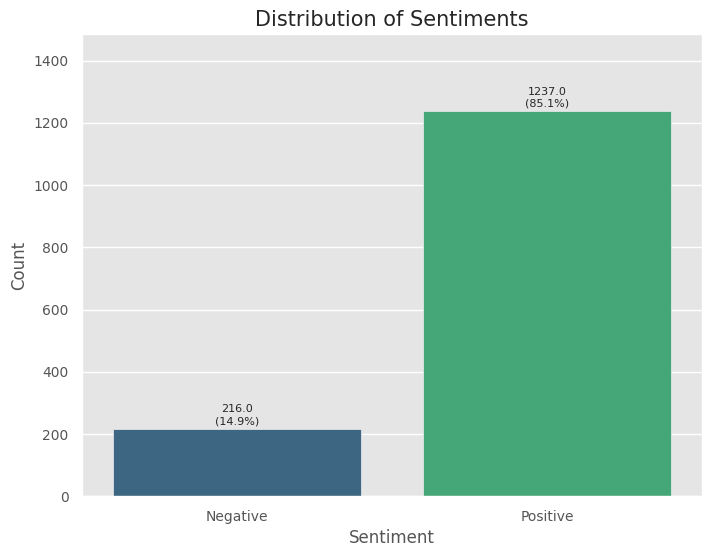

In [ ]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(x='Sentiment', data=df_reviews, palette='viridis')
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Count', fontsize=12)
plt.yticks(fontsize=10)
plt.title('Distribution of Sentiments', fontsize=15)

# Adding the value and the percentage of each bar
annotate_bars(ax, len(df_reviews), 'vertical')

# Ajudt the axis limits
adjust_axis_limits(ax, 'vertical', 1.2)

plt.show()

It's easy to see at a glance that reviews are positive, mostly. This shows us that most of people have a good services and experiences in restaurants, or at least, that they like to give good reviews.

### Country analysis

Now, let's see the countries and where we can find more reviews. This will help us to understand a little bit about the demographic of our reviewers.

In [ ]:
countries=df_reviews['Country'].value_counts()
countries

,count
Country,
France,490
Italy,296
Morroco,210
Cuba,141
Poland,135
Russia,100
India,81


Let's see this information in a graphic.

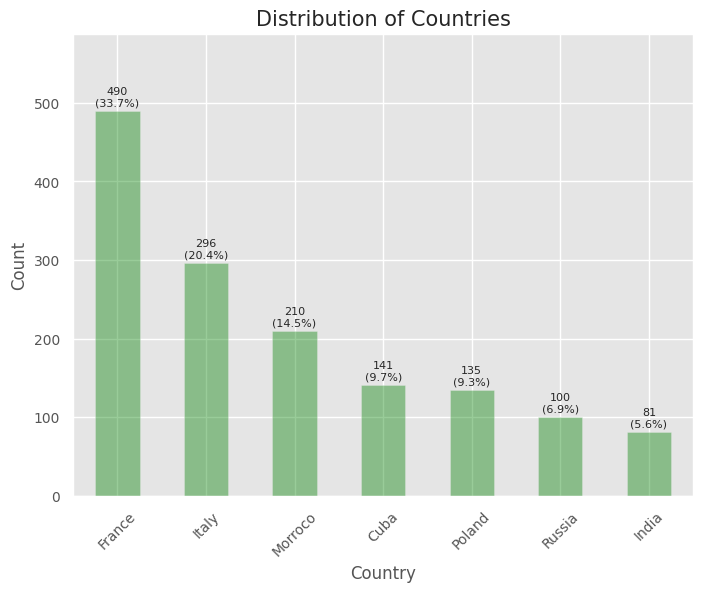

In [ ]:
plt.figure(figsize=(8, 6))
ax = countries.plot(kind='bar',color='Green',alpha=0.4)
plt.xticks(rotation=45)
plt.xlabel('Country', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Count', fontsize=12)
plt.yticks(fontsize=10)
plt.title('Distribution of Countries', fontsize=15)

# Adding the value and the percentage of each bar
annotate_bars(ax, len(df_reviews), 'vertical')

# Ajudt the axis limits
adjust_axis_limits(ax, 'vertical', 1.2)

plt.show()

The majority of the reviews were done in restaurants that are in France and Italy. This tells us that people in these countries place significant importance on sharing their dining experiences through reviews.

### Sentiment by Country

Now that we know our sentiment and country distributions, we can add a new graphic combining them.

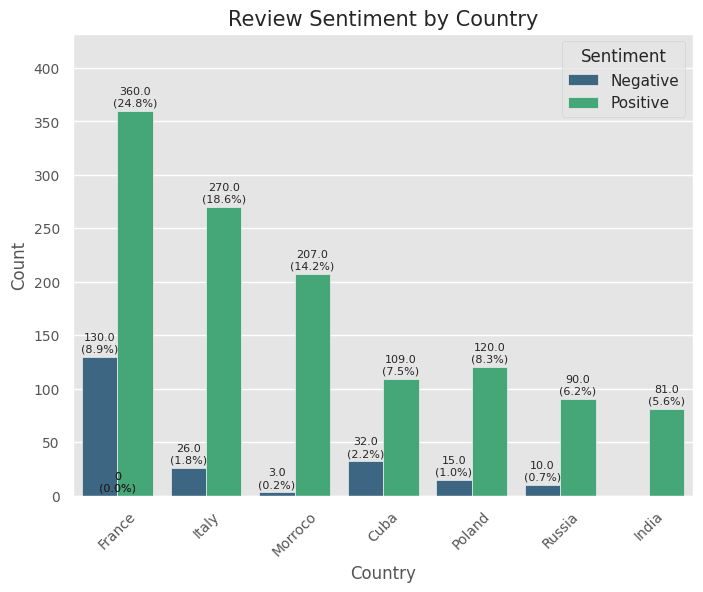

In [ ]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=df_reviews, x='Country', hue='Sentiment', palette='viridis', order=df_reviews['Country'].value_counts().index)
plt.xticks(rotation=45)
plt.xlabel('Country', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Count', fontsize=12)
plt.yticks(fontsize=10)
plt.title('Review Sentiment by Country', fontsize=15)

# Adding the value and the percentage of each bar
annotate_bars(ax, len(df_reviews), 'vertical')

# Ajudt the axis limits
adjust_axis_limits(ax, 'vertical', 1.2)

plt.show()

So, we can see in France, Italy and Morroco are the majority of the positive reviews.

### Top restaurants with most reviews

We can do this graphic to see which are the reaturants with most reviews.

<ipython-input-127-80ad208b36f8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_restaurants.values, y=top_restaurants.index, palette='viridis')


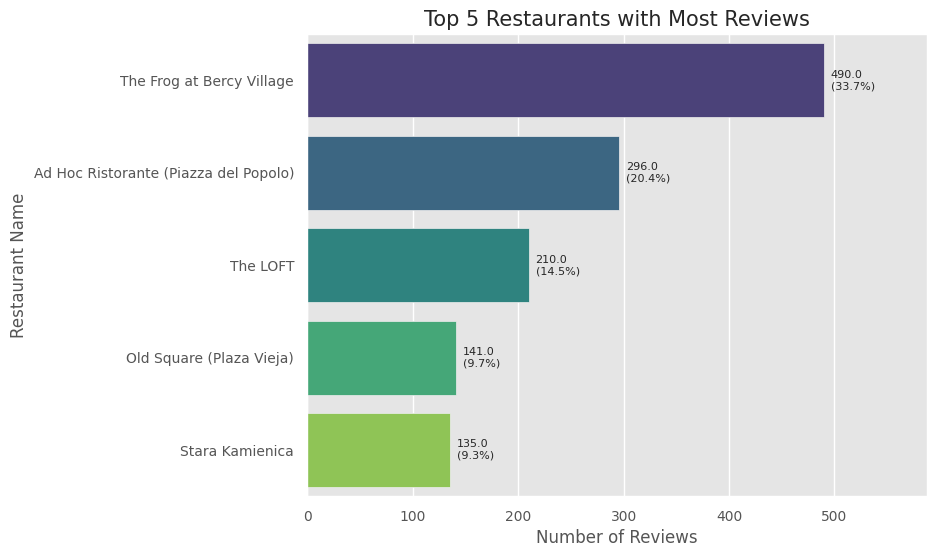

In [ ]:
top_restaurants = df_reviews['Restaurant Name'].value_counts().head(5)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=top_restaurants.values, y=top_restaurants.index, palette='viridis')
plt.xlabel('Number of Reviews', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Restaurant Name', fontsize=12)
plt.yticks(fontsize=10)
plt.title('Top 5 Restaurants with Most Reviews', fontsize=15)

# Adding the value and the percentage of each bar
annotate_bars(ax, len(df_reviews), 'horizontal')

# Ajudt the axis limits
adjust_axis_limits(ax, 'horizontal', 1.2)

plt.show()

Close to 70% of the reviews are in the top 3 restaurants (The Frog at Bercy Village, Ad Hoc Ristorante and The LOFT).

### Distribution of Review by Year

Let's see a distribution of the reviews by year. In order to do it, we can add a new column with the Year of each review.

<ipython-input-128-07098fdb3133>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.countplot(x='Review Year', data=df_reviews, palette='viridis', order=df_reviews['Review Year'].value_counts().sort_values(ascending=False).index)


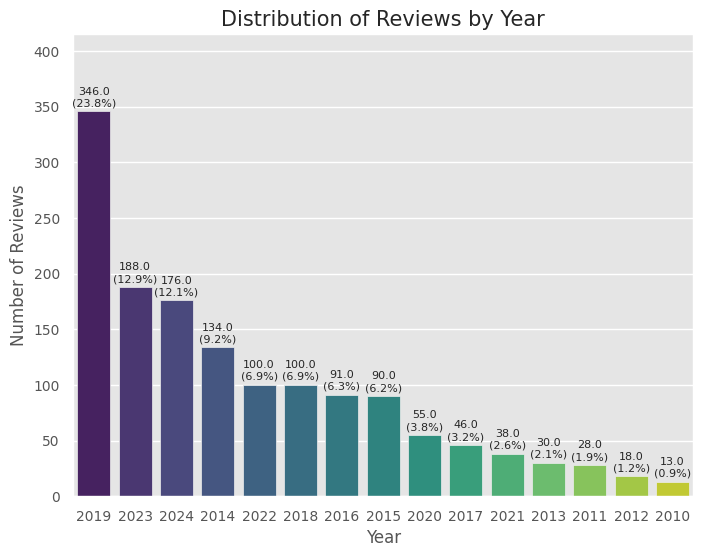

In [ ]:
# Extract the year using string slicing and regular expressions
df_reviews['Review Year'] = df_reviews['Review Date'].str.extract(r'(\d{4})').astype(int)

#Generate the graph of reviews per year
plt.figure(figsize=(8, 6))
ax= sns.countplot(x='Review Year', data=df_reviews, palette='viridis', order=df_reviews['Review Year'].value_counts().sort_values(ascending=False).index)
plt.xlabel('Year', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Number of Reviews', fontsize=12)
plt.yticks(fontsize=10)
plt.title('Distribution of Reviews by Year', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding the value and the percentage of each bar
annotate_bars(ax, len(df_reviews), 'vertical')

# Ajudt the axis limits
adjust_axis_limits(ax, 'vertical', 1.2)

plt.show()


2019 is the year with the majority of the reviews.

### Word clouds for reviews

Let's compare word clouds for both, positive and negative reviews.

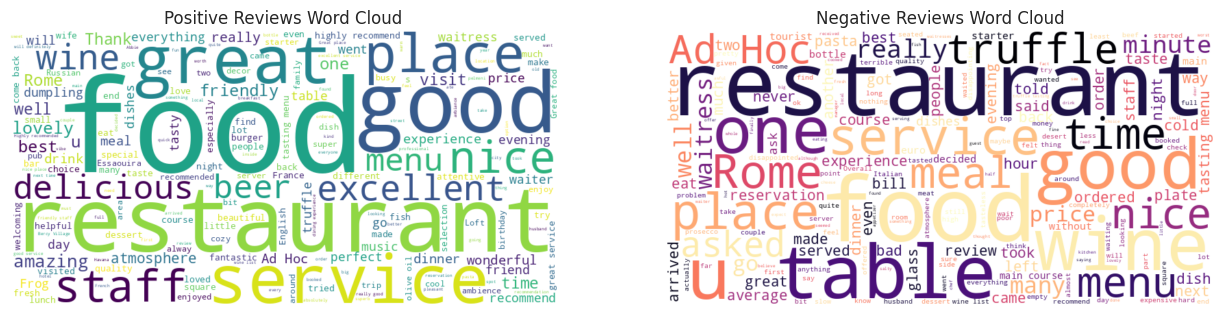

In [ ]:
# Split positive and negative reviews
positive_reviews = df_reviews[df_reviews['Sentiment'] == 'Positive']['Review'].str.cat(sep=' ')
negative_reviews = df_reviews[df_reviews['Sentiment'] == 'Negative']['Review'].str.cat(sep=' ')

# Create the word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(negative_reviews)

# Show the word clouds
plt.figure(figsize=(24, 12))

plt.subplot(1,3,1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud', fontsize=12)

plt.subplot(1,3,2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud', fontsize=12)

plt.show()

## 4. Text preprocessing

Let's do the text preprocessing function, but first let's create the corpus.

In [ ]:
# Create a corpus
corpus = df_reviews['Review'].tolist()

In [ ]:
def preprocess(text):
    # Tokenization
    words = nltk.word_tokenize(text)

    # Lowercase
    words = [word.lower() for word in words]

    # Remove punctuation
    words = [word for word in words if word not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

Now we can apply the preprocessing function to our corpus.

In [ ]:
# Apply preprocessing to the corpus
corpus = [preprocess(review) for review in corpus]

Let's see the most common words we have now, after preprocessing the reviews.

In [ ]:
# Flatten the corpus into a single list of words
all_words = [word for sublist in [review.split() for review in corpus] for word in sublist]

# Create a frequency distribution
fdist = Counter(all_words)

# Get the top 10 most common words
top_10_words = fdist.most_common(10)

# Display the most common words
print("Most common words:", top_10_words)

Most common words: [('food', 958), ('service', 665), ('restaurant', 647), ('good', 642), ('great', 619), ('place', 497), ('wine', 472), ('menu', 387), ('nice', 376), ('u', 366)]


Let's see it in a graph.

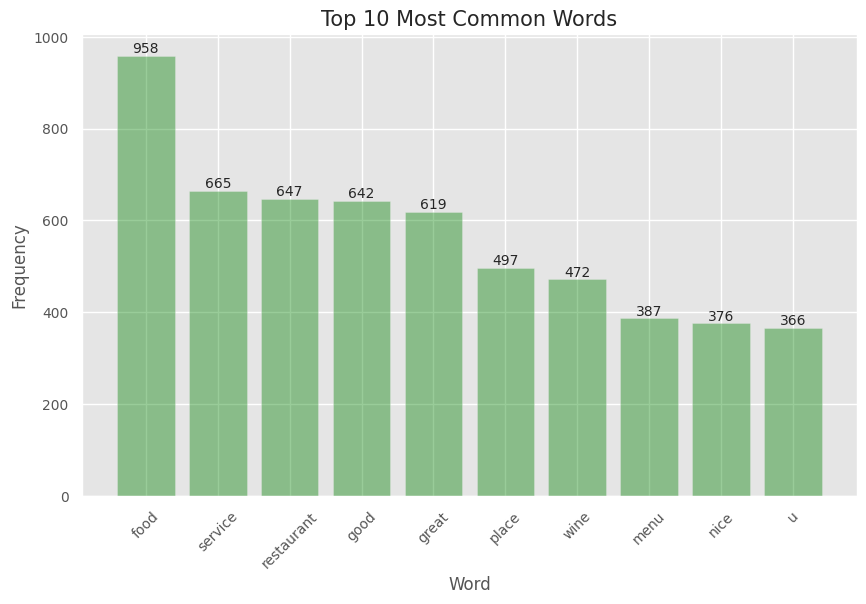

In [ ]:
# Extract words and frequencies
words, frequencies = zip(*top_10_words)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(words, frequencies, color='Green',alpha=0.4)
plt.xlabel('Word', fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel('Frequency', fontsize=12)
plt.yticks(fontsize=10)
plt.title('Top 10 Most Common Words', fontsize=15)
plt.xticks(rotation=45)
# Adding the values on top of each bar
for bar, frequency in zip(bars, frequencies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, frequency, ha='center', va='bottom', fontsize=10)

plt.show()

## 5. Feature selection

We will use the reviews (the preprocessed corpus) for X and our target variable (y) will be the sentiments. So let's encoded them to use numerical values.

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_reviews['Sentiment'])

Now, during the EDA, when we calculated the distribution of sentiment, we realized there is a significant imbalance. In order to avoid overfitting, we should apply a technique like resampling with RandomUnderSampler.

In [ ]:
# Under-sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

## 6. The model

Now we can split data into training, validation and test sets, create several models to evaluate the best one for the sentiment analysis, and use that one.

In [ ]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [ ]:
# Define models and parameters for each one
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20]
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.1, 0.01],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200]
        }
    }
}

Define a function to evaluate the models in a consistent way.

In [ ]:
# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    confusion = confusion_matrix(y_val, y_pred)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'confusion': confusion}

Let's train and evaluate the models.

In [ ]:
# Train and evaluate models
model_performance = {}
for model_name, config in models.items():
    clf = GridSearchCV(config['model'], config['params'], cv=5, scoring='f1')
    clf.fit(X_train, y_train)
    best_model = clf.best_estimator_

    metrics = evaluate_model(best_model, X_train, y_train, X_val, y_val)
    model_performance[model_name] = metrics
    print(f"{model_name}: Accuracy={metrics['accuracy']}, Precision={metrics['precision']}, Recall={metrics['recall']}, F1={metrics['f1']}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

LogisticRegression: Accuracy=0.9534883720930233, Precision=0.9545454545454546, Recall=0.9545454545454546, F1=0.9545454545454546
RandomForestClassifier: Accuracy=0.9069767441860465, Precision=0.875, Recall=0.9545454545454546, F1=0.9130434782608695
SVC: Accuracy=0.9069767441860465, Precision=0.9090909090909091, Recall=0.9090909090909091, F1=0.9090909090909091
MultinomialNB: Accuracy=0.8837209302325582, Precision=0.9473684210526315, Recall=0.8181818181818182, F1=0.8780487804878049
KNeighborsClassifier: Accuracy=0.813953488372093, Precision=0.8888888888888888, Recall=0.7272727272727273, F1=0.7999999999999999
XGBClassifier: Accuracy=0.8372093023255814, Precision=0.8571428571428571, Recall=0.8181818181818182, F1=0.8372093023255814


Now that we evaluated them, let's select the best one, based on its validation performance value.

In [ ]:
# Select the best model based on validation performance
best_model_name = max(model_performance, key=lambda k: model_performance[k]['f1'])
best_model = models[best_model_name]['model']

Now we can refit the best model on training set and predict on test.

In [ ]:
# Refit the best model on the entire training set
best_model.fit(X_train, y_train)

# Use the best model to predict on the test set
y_pred = best_model.predict(X_test)

Let's chek it on test set and see its metric values.

In [ ]:
# Evaluate the best model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1}")
print(f"Confusion Matrix:\n{confusion}")

Best Model: LogisticRegression
Test Accuracy: 0.8505747126436781
Test Precision: 0.7619047619047619
Test Recall: 0.9142857142857143
Test F1-Score: 0.8311688311688312
Confusion Matrix:
[[42 10]
 [ 3 32]]


## 7. Checking the model with samples

Now that we created several models and selected the best ones based on performance, let's check wth a few manual reviews, to verify if the sentiment prediction is quite.

Let's define a few sample reviews.

In [ ]:
sample_reviews = ["This restaurant was amazing! The food was delicious and the service was excellent.",
                  "I would never choose you again",
                  "I hate this restaurant",
                  "The best restaurant ever",
                  "It was just good",
                  "I think I will come back",
                  "Too expensive",
                  "The worst dining experience ever. The food was cold and the waiter was rude."]

Preprocessed the sample and predict with it.

In [ ]:
sample_reviews_preprocessed = [preprocess(review) for review in sample_reviews]
sample_reviews_vectorized = vectorizer.transform(sample_reviews_preprocessed)
sample_predictions = best_model.predict(sample_reviews_vectorized)

Now, let's the the prediction for each example.

In [ ]:
# Map numerical predictions to text labels with numbers in parentheses
predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in sample_predictions]

# Create a dictionary to pair reviews with their formatted predicted labels
results = dict(zip(sample_reviews, predicted_labels_formatted))

# Print the results
for review, prediction in results.items():
    print(f"Review: {review}\nPrediction: {prediction}\n")

Review: This restaurant was amazing! The food was delicious and the service was excellent.
Prediction: Positive (1)

Review: I would never choose you again
Prediction: Negative (0)

Review: I hate this restaurant
Prediction: Positive (1)

Review: The best restaurant ever
Prediction: Positive (1)

Review: It was just good
Prediction: Positive (1)

Review: I think I will come back
Prediction: Positive (1)

Review: Too expensive
Prediction: Negative (0)

Review: The worst dining experience ever. The food was cold and the waiter was rude.
Prediction: Positive (1)



Overall, the model seems to perform reasonably well on the unseen data. Nevertheless, we can argue that for some examples, like "It was just good", where we don't have strong positive or negative opinions, the model tends to be optimistic, focusing on positive words and ignoring negative sentiment. There are a few alternatives to improve this, like expanding the dataset or trying different models.

Let's do the same evaluation, but with some random reviews from the corpus.

In [ ]:
def get_random_reviews(corpus, num_reviews=10):
  random_indices = random.sample(range(len(corpus)), num_reviews)
  random_reviews = [corpus[i] for i in random_indices]
  return random_reviews

# Get 10 random reviews
random_reviews = get_random_reviews(corpus, 10)

# Preprocess and vectorize random reviews
random_reviews_preprocessed = [preprocess(review) for review in random_reviews]
random_reviews_vectorized = vectorizer.transform(random_reviews_preprocessed)

# Predict sentiments for random reviews
random_predictions = best_model.predict(random_reviews_vectorized)

# Map numerical predictions to text labels with numbers in parentheses
random_predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in random_predictions]

# Create a dictionary to pair reviews with their formatted predicted labels
random_results = dict(zip(random_reviews, random_predicted_labels_formatted))

# Print the results
for review, prediction in random_results.items():
    print(f"Review: {review}\nPrediction: {prediction}\n")


Review: stopped lite bite drink arrival france young girl called abbie served u super friendly efficient helpful reason reserved table returned confernece buffet hote.l chicken wing poppadoms amazing
Prediction: Positive (1)

Review: service took long asked several time speedier service attend event ordered speciality pirogi pork chop available large part menu ordered wanted pay separately aggressive waiter ’ want making weird explanation tone aggressive almost little bit physical totally open feedback shocked good story tell 150 delegate event problem ’ care explained u best waiter warsaw perhaps also poland excuse would better reaction
Prediction: Negative (0)

Review: really loved square lovely atmosphere lot people guided tour operator stayed nearby raquel hotel night returning 12 day trip cuba recommend area full character
Prediction: Positive (1)

Review: bar mix brand lager bit different ginger style one enjoyed bar young crowd easily busiest place bercy village drink would chec

## 8. Conclusion

The primary objective of this project was to develop a model capable of classifying restaurant reviews as positive or negative (binary classification). A **Logistic Regression** model was selected as the best one, after evaluating and implementing it on a dataset of 1502 reviews.
<br><br>
Initial performance metrics indicated **promising results**. However, a deeper analysis through manual and random sample evaluations revealed **some limitations** in capturing nuanced sentiments and potential overfitting issues. While the model effectively classified reviews with strong sentiment polarity, it struggled to accurately categorize reviews expressing mixed emotions or subtle opinions, (like "It was just good").
<br><br>
There are different ways to address these challenges, and it could be necessary further research, including advanced text preprocessing techniques, incorporating more sophisticated algorithms, and expanding the dataset to enhance the model's ability to handle complex linguistic patterns.
<br><br>
By addressing these areas, the model's generalizability can be enhanced, providing valuable insights for businesses seeking to understand customer sentiment.